# Project: Population & Hospitals
# Author: Dilnaz Zeinolla & Zhumanova Zhanel
# Course: Data Collection & Preparation
# Date: October 2025

"""
Цель проекта:
Исследовать, как количество больниц связано с численностью населения и долей пожилых людей (65+)
в разных странах, используя реальные данные из World Bank API и Wikipedia.
"""


In [8]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

countries = [
    {"name": "Kazakhstan", "iso2": "KZ", "region": "Asia"},
    {"name": "Japan", "iso2": "JP", "region": "Asia"},
    {"name": "Germany", "iso2": "DE", "region": "Europe"},
    {"name": "France", "iso2": "FR", "region": "Europe"},
    {"name": "United States", "iso2": "US", "region": "North America"},
    {"name": "Canada", "iso2": "CA", "region": "North America"}
]

Получение данных из World Bank API

In [9]:
population_data = []

for country in countries:
    pop_url = f"https://api.worldbank.org/v2/country/{country['iso2']}/indicator/SP.POP.TOTL?format=json"
    elderly_url = f"https://api.worldbank.org/v2/country/{country['iso2']}/indicator/SP.POP.65UP.TO.ZS?format=json"

    pop_resp = requests.get(pop_url).json()
    elderly_resp = requests.get(elderly_url).json()

    pop_value = next(item["value"] for item in pop_resp[1] if item["value"] is not None)
    elderly_percent = next(item["value"] for item in elderly_resp[1] if item["value"] is not None)

    population_data.append({
        "Country": country["name"],
        "Region": country["region"],
        "Population": int(pop_value),
        "Elderly_percent": elderly_percent
    })

df_population = pd.DataFrame(population_data)
df_population


,Country,Region,Population,Elderly_percent
0,Kazakhstan,Asia,20592571,8.653235
1,Japan,Asia,123975371,29.780770
2,Germany,Europe,83510950,23.195587
3,France,Europe,68516699,22.146562
4,United States,North America,340110988,17.928730
5,Canada,North America,41288599,19.799591


Скрапинг Wikipedia

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

hospital_data = []

wiki_links = {
    "Kazakhstan": "https://en.wikipedia.org/wiki/List_of_hospitals_in_Kazakhstan",
    "Japan": "https://en.wikipedia.org/wiki/List_of_hospitals_in_Japan",
    "Germany": "https://en.wikipedia.org/wiki/List_of_hospitals_in_Germany",
    "France": "https://en.wikipedia.org/wiki/List_of_hospitals_in_France",
    "United States": "https://en.wikipedia.org/wiki/List_of_hospitals_in_the_United_States",
    "Canada": "https://en.wikipedia.org/wiki/List_of_hospitals_in_Canada"
}

headers = {"User-Agent": "Mozilla/5.0"}

for country, url in wiki_links.items():
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, "lxml")

    content = soup.find("div", {"class": "mw-parser-output"})
    if content:
        hospitals = len(content.find_all("li"))
    else:
        hospitals = 0

    hospital_data.append({"Country": country, "Hospitals": hospitals})

df_hospitals = pd.DataFrame(hospital_data)
df_hospitals


,Country,Hospitals
0,Kazakhstan,160
1,Japan,379
2,Germany,75
3,France,156
4,United States,415
5,Canada,712


Объединение и расчёт метрик

In [11]:
df = pd.merge(df_population, df_hospitals, on="Country")

df["Elderly_population"] = (df["Population"] * df["Elderly_percent"]) / 100
df["Hospitals_per_million"] = df["Hospitals"] / (df["Population"] / 1_000_000)
df["Hospitals_per_million_elderly"] = df["Hospitals"] / (df["Elderly_population"] / 1_000_000)

df


,Country,Region,Population,Elderly_percent,Hospitals,Elderly_population,Hospitals_per_million,Hospitals_per_million_elderly
0,Kazakhstan,Asia,20592571,8.653235,160,1.781923e+06,7.769792,89.790611
1,Japan,Asia,123975371,29.780770,379,3.692082e+07,3.057059,10.265211
2,Germany,Europe,83510950,23.195587,75,1.937086e+07,0.898086,3.871796
3,France,Europe,68516699,22.146562,156,1.517409e+07,2.276817,10.280680
4,United States,North America,340110988,17.928730,415,6.097758e+07,1.220190,6.805780
5,Canada,North America,41288599,19.799591,712,8.174974e+06,17.244470,87.095082


Корреляция (Population vs Hospitals)

Корреляция между населением и количеством больниц: 0.17


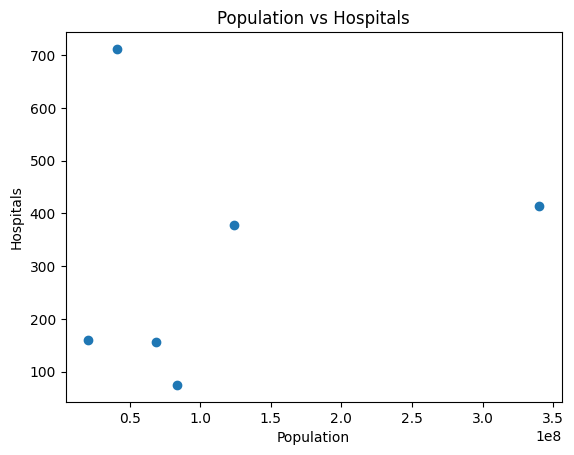

In [12]:
corr = df["Population"].corr(df["Hospitals"])
print("Корреляция между населением и количеством больниц:", round(corr, 3))

plt.scatter(df["Population"], df["Hospitals"])
plt.title("Population vs Hospitals")
plt.xlabel("Population")
plt.ylabel("Hospitals")
plt.show()


Active Healthcare Population (65+)

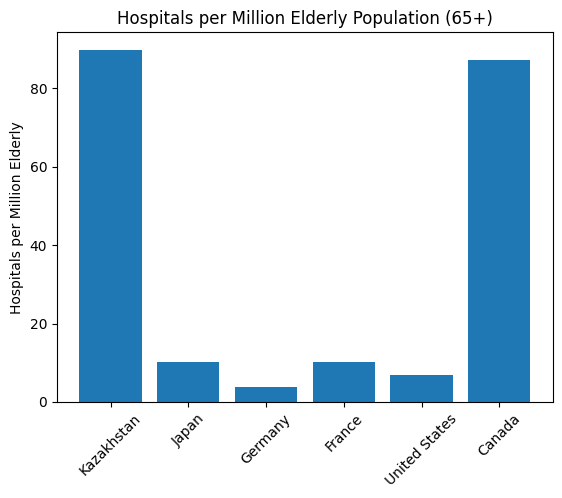

In [13]:
plt.bar(df["Country"], df["Hospitals_per_million_elderly"])
plt.title("Hospitals per Million Elderly Population (65+)")
plt.ylabel("Hospitals per Million Elderly")
plt.xticks(rotation=45)
plt.show()


Regional Hospital Density

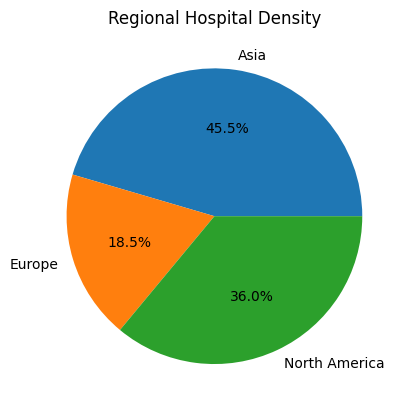

In [14]:
region_stats = df.groupby("Region").agg({
    "Population": "sum",
    "Hospitals": "sum"
}).reset_index()

region_stats["Hospitals_per_million"] = region_stats["Hospitals"] / (region_stats["Population"] / 1_000_000)

plt.pie(region_stats["Hospitals_per_million"], labels=region_stats["Region"], autopct="%1.1f%%")
plt.title("Regional Hospital Density")
plt.show()
